In [8]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# To show images
from PIL import Image

# Create Functions

#### Create data frame

In [10]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Collect all data into one dataframe
def create_df(dataset):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for filename in filenames:
            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths, 'Label': labels})
    return df

train_dir = "D:/Omkar research work/Blood cancer work/dataset/training_data"
df = create_df(train_dir)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))
print("Number of validation samples: %d" % len(valid_df.index))


Number of training samples: 5026
Number of test samples: 1078
Number of validation samples: 1077


#### Display Model Performance

In [12]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

#### Confusion Matrix

In [14]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[True, False])

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()

#### Evaluation Matrix

In [16]:
from sklearn.metrics import classification_report

def evaluation_matrix(model, test_gen, test_df, batch_size):
    # Evaluate on train, validation, and test data
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps=test_steps, verbose=0)
    valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=0)
    test_score = model.evaluate(test_gen, steps=test_steps, verbose=0)

    # Prediction on the test set for classification report
    test_gen.reset()
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Classification report
    class_report = classification_report(y_true, y_pred_labels, target_names=test_gen.class_indices.keys())

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy")
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    # Print classification report
    print("\n" + "="*50)
    print("Classification Report:\n")
    print(class_report)

    # Print accuracy and loss
    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)


#### Show Images

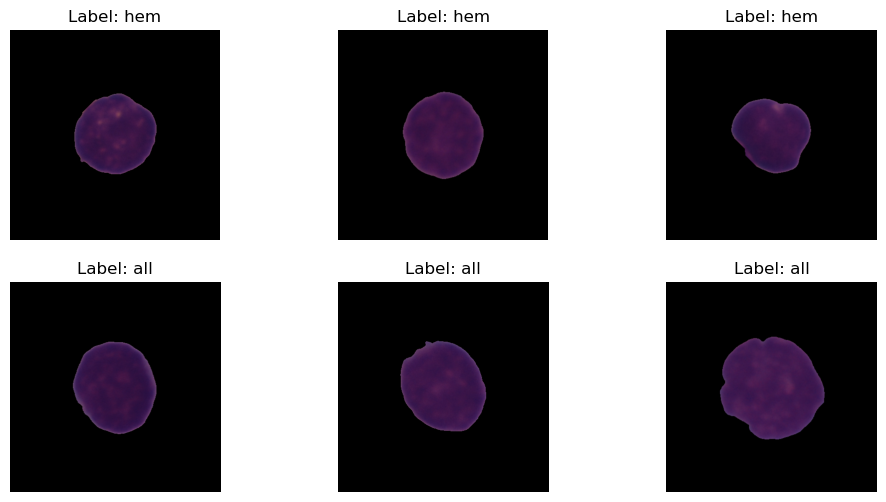

In [18]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

#### Initializing Image Data Generators

In [20]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size

Found 5026 validated image filenames belonging to 2 classes.
Found 1077 validated image filenames belonging to 2 classes.
Found 1078 validated image filenames belonging to 2 classes.


# Classification Models

## VGG19

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adamax
from tensorflow import keras

# Define input shape for the model
img_shape = (224, 224, 3)

# Instantiate the VGG19 base model with pre-trained weights from ImageNet
VGG19_base_model = VGG19(weights='imagenet', input_shape=img_shape, include_top=False, pooling=None)

# Freeze the base model to keep pre-trained weights intact
VGG19_base_model.trainable = False

# Add custom top layers for binary classification
last_layer = VGG19_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='sigmoid')(x)  # For binary classification

# Create the final model
VGG19_model = tf.keras.Model(VGG19_base_model.input, x, name="VGG19_model")

# Compile the model with Adamax optimizer, categorical crossentropy, and accuracy as metrics
VGG19_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
VGG19_model.summary()


Model: "VGG19_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,025,410 (76.39 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

#### Train Model

In [22]:
epochs = 5

history_VGG19 = VGG19_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.5785 - loss: 7.3409 - val_accuracy: 0.6865 - val_loss: 2.9944
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6160 - loss: 4.8829 - val_accuracy: 0.7838 - val_loss: 1.6241
Epoch 3/5


C:\Users\MIC LAB\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


27/27 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.5858 - loss: 5.2028 - val_accuracy: 0.7144 - val_loss: 1.8986
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6182 - loss: 4.7020 - val_accuracy: 0.8108 - val_loss: 1.4264
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.6155 - loss: 4.7793 - val_accuracy: 0.7385 - val_loss: 2.0721


#### Evaluate Model

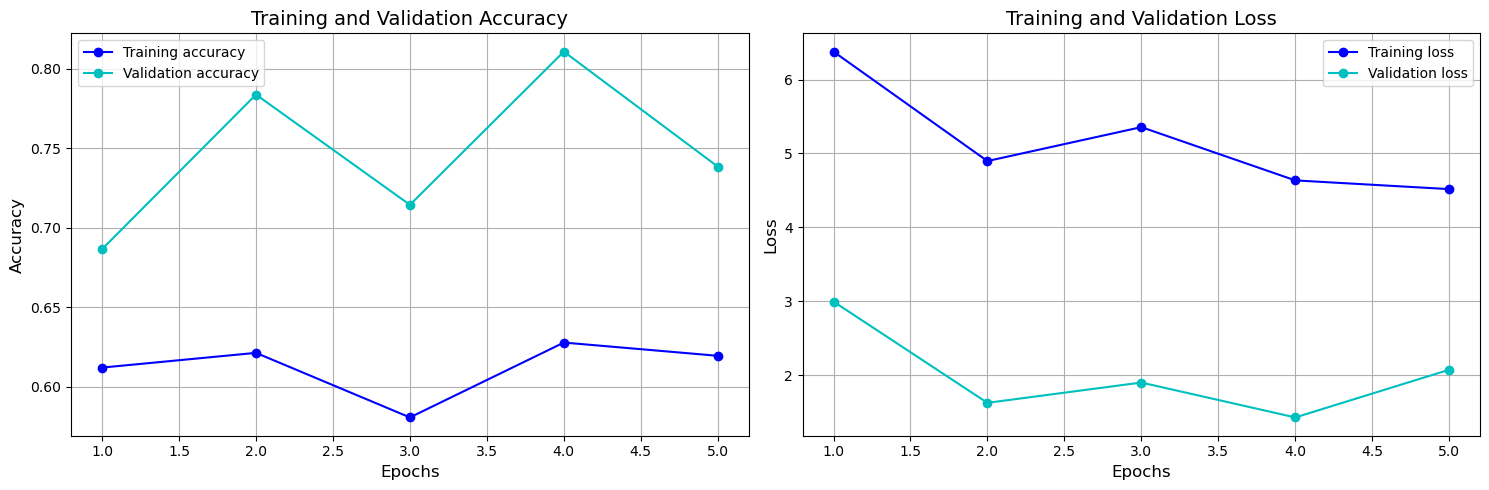

In [28]:
show_history_plot(history_VGG19.history)

In [30]:
evaluation_matrix(VGG19_model, test_gen, test_df, batch_size)

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Classification Report:

              precision    recall  f1-score   support

         all       0.73      0.91      0.81       712
         hem       0.68      0.36      0.47       366

    accuracy                           0.72      1078
   macro avg       0.71      0.63      0.64      1078
weighted avg       0.71      0.72      0.70      1078

             Loss       Accuracy  
----------------------------------
Train        1.91166    0.75288   
Validation   2.03764    0.73462   
Test         2.22097    0.72596   


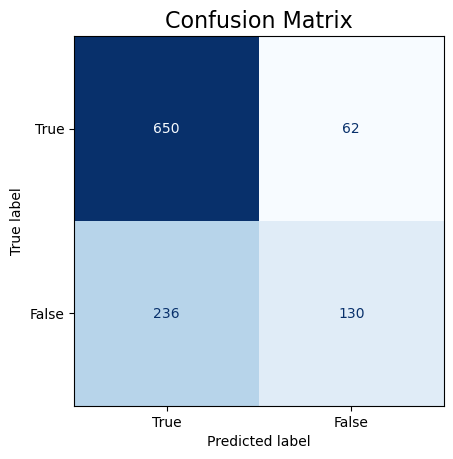

<Figure size 700x700 with 0 Axes>

In [31]:
show_conf_matrix(VGG19_model)

## EfficientNetv2B0

In [44]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import Input

# Define the input tensor with a valid shape for EfficientNetB7
input_tensor = Input(shape=(224, 224, 3))

# Load the EfficientNetB7 model with input_tensor
ENv2_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    pooling='max'
)

# Build the model
ENv2_model = Sequential([
    ENv2_base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.45),
    Dense(2, activation='softmax')  # Adjust to your number of classes
])

# Compile the model
ENv2_model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
ENv2_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,882 (23.85 MB)

 Trainable params: 6,189,714 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

#### Train Model

In [46]:
epochs = 5

history_ENv2 = ENv2_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/5


C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_305']. Received: the structure of inputs=*
  warnings.warn(


126/126 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7364 - loss: 0.7354 - val_accuracy: 0.8347 - val_loss: 0.4073
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.8301 - loss: 0.4543 - val_accuracy: 0.8979 - val_loss: 0.2856
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.8816 - loss: 0.3006 - val_accuracy: 0.9016 - val_loss: 0.2360
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.8944 - loss: 0.2715 - val_accuracy: 0.9248 - val_loss: 0.1968
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9337 - loss: 0.1793 - val_accuracy: 0.9192 - val_loss: 0.2417


#### Evaluate Model

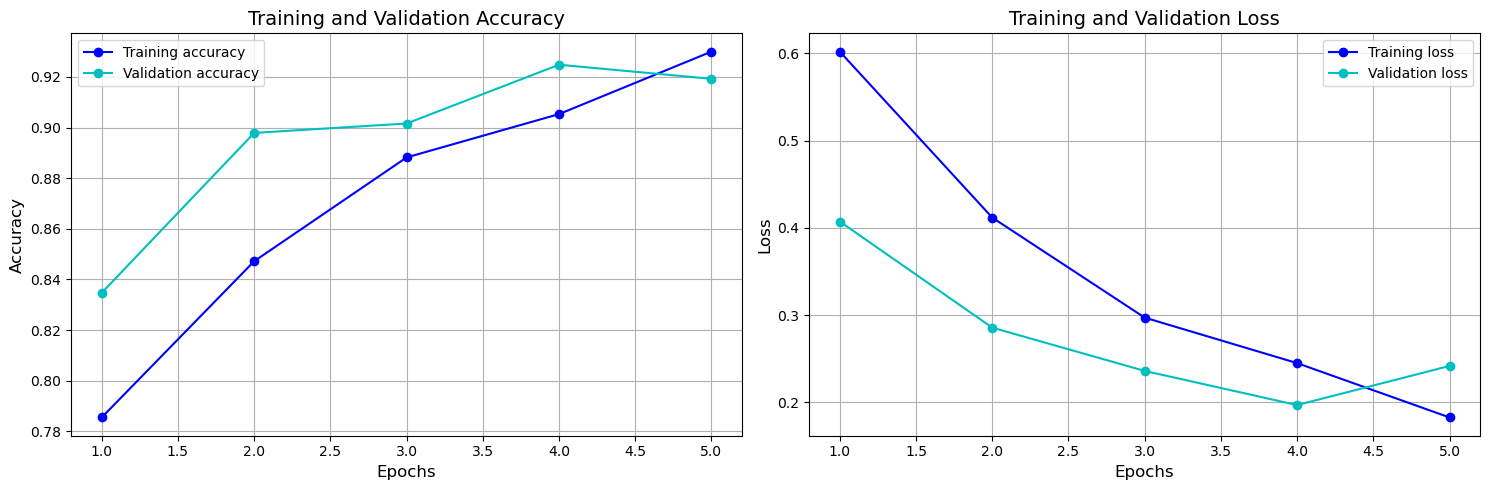

In [48]:
show_history_plot(history_ENv2.history)

In [52]:
evaluation_matrix(ENv2_model,test_gen, test_df, batch_size)

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_305']. Received: the structure of inputs=*
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

         all       0.90      0.98      0.94       712
         hem       0.96      0.79      0.87       366

    accuracy                           0.92      1078
   macro avg       0.93      0.89      0.90      1078
weighted avg       0.92      0.92      0.91      1078

             Loss       Accuracy  
----------------------------------
Train        0.10965    0.96250   
Validation   0.24366    0.91923   
Test         0.25001    0.91442   


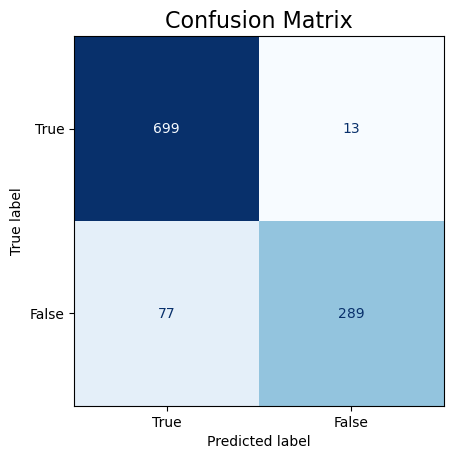

<Figure size 700x700 with 0 Axes>

In [54]:
show_conf_matrix(ENv2_model)

In [ ]:
#####Efficentnetv2B0 leaky Relu

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import Input

# Define the input tensor with a valid shape for EfficientNetB7
input_tensor = Input(shape=(224, 224, 3))

# Load the EfficientNetB7 model with input_tensor
ENv2_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    pooling='max'
)

# Build the model
ENv2_model = Sequential([
    ENv2_base_model,
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.45),
    Dense(2, activation='softmax')  # Adjust to your number of classes
])

# Compile the model
ENv2_model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
ENv2_model.summary()

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,882 (23.85 MB)

 Trainable params: 6,189,714 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [58]:
epochs = 5

history_ENv2 = ENv2_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/5


C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_582']. Received: the structure of inputs=*
  warnings.warn(


126/126 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.7384 - loss: 0.7203 - val_accuracy: 0.8570 - val_loss: 0.4275
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.8420 - loss: 0.4225 - val_accuracy: 0.9081 - val_loss: 0.2543
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8886 - loss: 0.2774 - val_accuracy: 0.8960 - val_loss: 0.3043
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9047 - loss: 0.2362 - val_accuracy: 0.9006 - val_loss: 0.2518
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9343 - loss: 0.1781 - val_accuracy: 0.9276 - val_loss: 0.1892


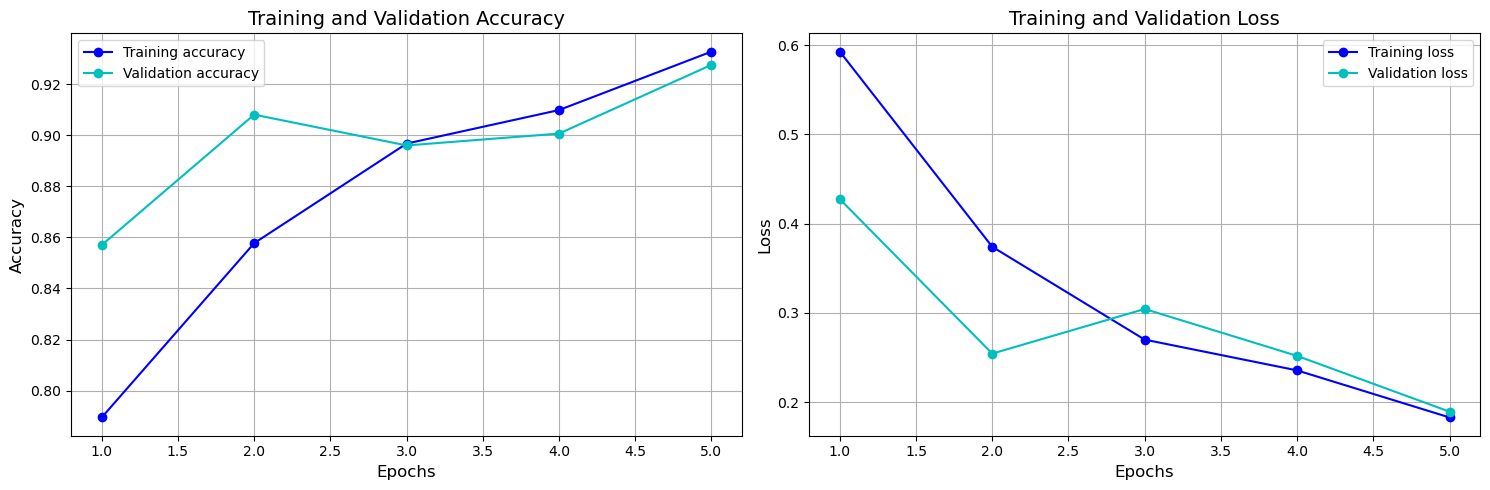

In [62]:
##Evaluate model
show_history_plot(history_ENv2.history)

In [64]:
evaluation_matrix(ENv2_model,test_gen, test_df, batch_size)

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_582']. Received: the structure of inputs=*
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

         all       0.92      0.99      0.95       712
         hem       0.97      0.83      0.89       366

    accuracy                           0.93      1078
   macro avg       0.94      0.91      0.92      1078
weighted avg       0.93      0.93      0.93      1078

             Loss       Accuracy  
----------------------------------
Train        0.10132    0.96250   
Validation   0.19155    0.92692   
Test         0.18907    0.93077   


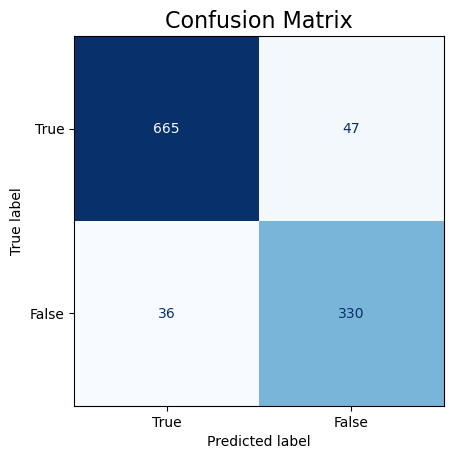

<Figure size 700x700 with 0 Axes>

In [30]:
show_conf_matrix(ENv2_model)

In [20]:
#####Efficentnetv2B3 leaky Relu

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import Input

# Define the input tensor with a valid shape for EfficientNetB7
input_tensor = Input(shape=(224, 224, 3))

# Load the EfficientNetB7 model with input_tensor
ENv2_base_model = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    pooling='max'
)

# Build the model
ENv2_model = Sequential([
    ENv2_base_model,
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.45),
    Dense(2, activation='softmax')  # Adjust to your number of classes
])

# Compile the model
ENv2_model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
ENv2_model.summary()

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,330,752 (50.85 MB)

 Trainable params: 13,218,464 (50.42 MB)

 Non-trainable params: 112,288 (438.62 KB)

In [24]:
epochs = 5

history_ENv2 = ENv2_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/5


C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


126/126 ━━━━━━━━━━━━━━━━━━━━ 631s 4s/step - accuracy: 0.7459 - loss: 0.7622 - val_accuracy: 0.8663 - val_loss: 0.4387
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - accuracy: 0.8343 - loss: 0.4373 - val_accuracy: 0.9062 - val_loss: 0.2339
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.8998 - loss: 0.2534 - val_accuracy: 0.9146 - val_loss: 0.2390
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.9287 - loss: 0.1847 - val_accuracy: 0.9359 - val_loss: 0.1741
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.9401 - loss: 0.1664 - val_accuracy: 0.9239 - val_loss: 0.1992


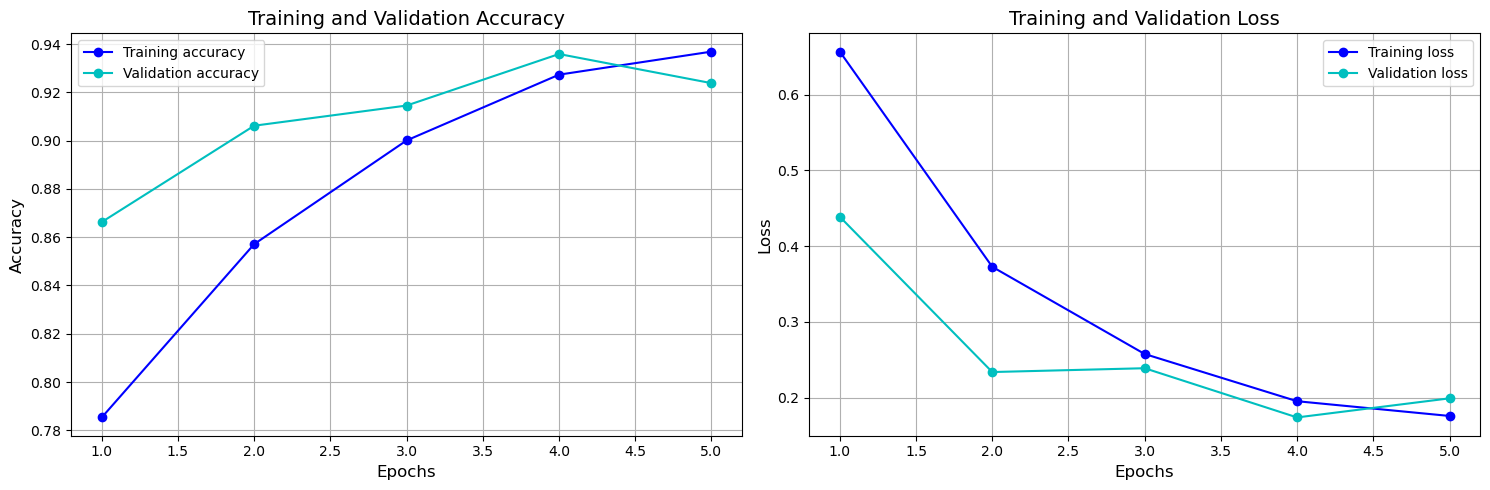

In [26]:
##Evaluate model
show_history_plot(history_ENv2.history)

In [28]:
evaluation_matrix(ENv2_model,test_gen, test_df, batch_size)

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

         all       0.95      0.93      0.94       712
         hem       0.88      0.90      0.89       366

    accuracy                           0.92      1078
   macro avg       0.91      0.92      0.91      1078
weighted avg       0.92      0.92      0.92      1078

             Loss       Accuracy  
----------------------------------
Train        0.08978    0.96635   
Validation   0.19480    0.92404   
Test         0.19844    0.92308   


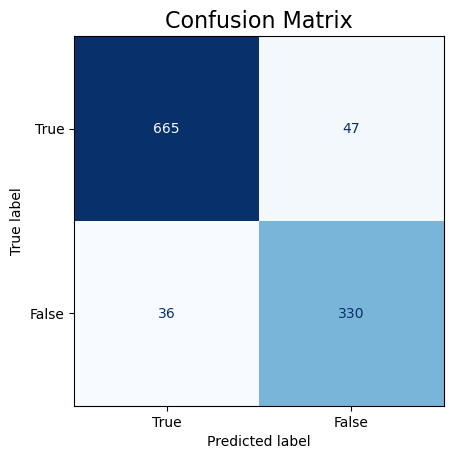

<Figure size 700x700 with 0 Axes>

In [32]:
show_conf_matrix(ENv2_model)

In [2]:
### EffNetV2B3 with Parametric Relu
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout,  PReLU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import Input

# Define the input tensor with a valid shape for EfficientNetB7
input_tensor = Input(shape=(224, 224, 3))

# Load the EfficientNetV2B3 model with input_tensor
ENv2_base_model = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    pooling='max'
)

# Build the model
ENv2_model = Sequential([
    ENv2_base_model,
    BatchNormalization(),
    Dense(256),
    PReLU(),
    Dropout(0.45),
    Dense(2, activation='softmax')  # Adjust to your number of classes
])

# Compile the model
ENv2_model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
ENv2_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,331,008 (50.85 MB)

 Trainable params: 13,218,720 (50.43 MB)

 Non-trainable params: 112,288 (438.62 KB)

In [ ]:
epochs = 5

history_ENv2 = ENv2_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


C:\Users\MIC LAB\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


126/126 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - accuracy: 0.7560 - loss: 0.7349 - val_accuracy: 0.8895 - val_loss: 0.3153
Epoch 2/5
 77/126 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.8560 - loss: 0.4067

## LeNet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import categorical_crossentropy

# Define the LeNet model architecture
LeNet_model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the LeNet model
LeNet_model.compile(optimizer=Adamax(learning_rate=0.001),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])


LeNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 120)               5

#### Train the Model

In [ ]:
# Train the LeNet model
epochs = 5

history_LeNet = LeNet_model.fit(train_gen,
                                steps_per_epoch=train_steps,
                                validation_data=valid_gen,
                                validation_steps=validation_steps,
                                epochs=epochs,
                                verbose=1)

Epoch 1/5
50/50 [==============================] - 281s 5s/step - loss: 2.4931 - accuracy: 0.8345 - val_loss: 4.7818 - val_accuracy: 0.7531
Epoch 2/5
50/50 [==============================] - 265s 5s/step - loss: 1.4390 - accuracy: 0.8613 - val_loss: 2.0308 - val_accuracy: 0.7456
Epoch 3/5
50/50 [==============================] - 263s 5s/step - loss: 1.1045 - accuracy: 0.8926 - val_loss: 2.6532 - val_accuracy: 0.7488
Epoch 4/5
50/50 [==============================] - 266s 5s/step - loss: 1.1252 - accuracy: 0.9014 - val_loss: 2.0084 - val_accuracy: 0.7338
Epoch 5/5
50/50 [==============================] - 263s 5s/step - loss: 0.9464 - accuracy: 0.8821 - val_loss: 2.3812 - val_accuracy: 0.7550


#### Evaluate Model

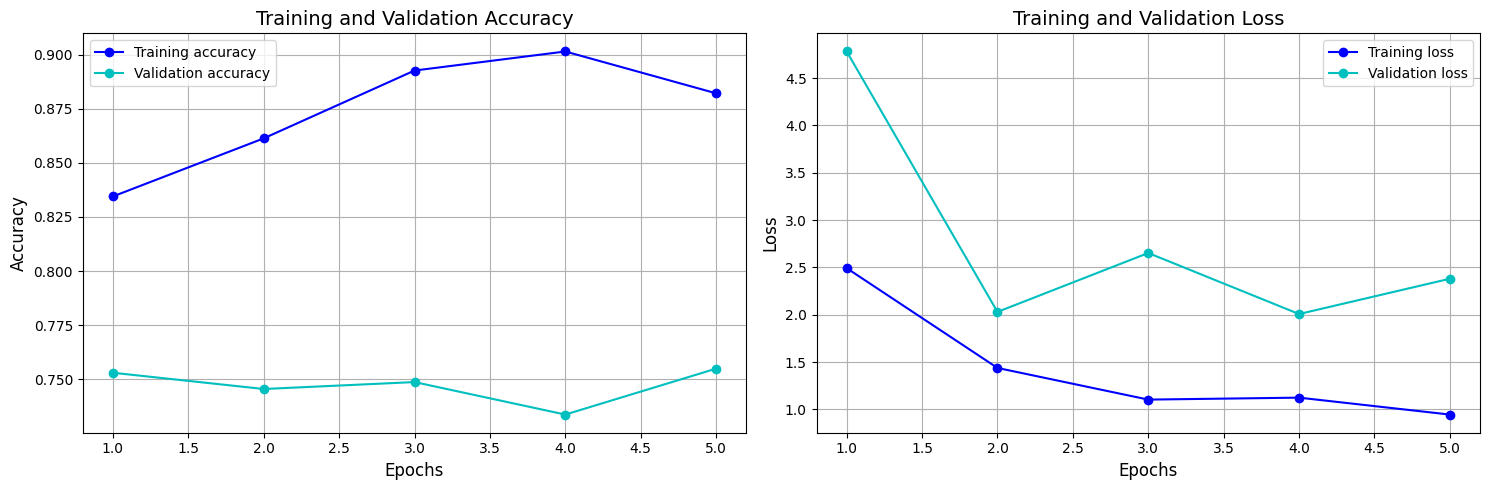

In [ ]:
show_history_plot(history_LeNet.history)

In [ ]:
evaluation_matrix(LeNet_model)

             Loss       Accuracy 
----------------------------------
Train        0.94645    0.88216   
Validation   0.38123    0.75507   
Test         0.66389    0.83588   


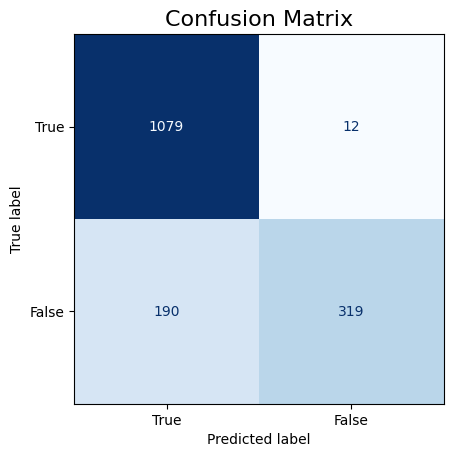

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(LeNet_model)

## AlexNet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import categorical_crossentropy

# Define the AlexNet model architecture
AlexNet_model = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the AlexNet model
AlexNet_model.compile(optimizer=Adamax(learning_rate=0.001),
                      loss=categorical_crossentropy,
                      metrics=['accuracy'])

# Print model summary
AlexNet_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 384)      

#### Train the Model

In [ ]:
history_AlexNet = AlexNet_model.fit(train_gen,
                                    steps_per_epoch=train_steps,
                                    validation_data=valid_gen,
                                    validation_steps=validation_steps,
                                    epochs=epochs,
                                    verbose=1)

Epoch 1/5
50/50 [==============================] - 90s 2s/step - loss: 2.1986 - accuracy: 0.7667 - val_loss: 4.4861 - val_accuracy: 0.6462
Epoch 2/5
50/50 [==============================] - 87s 2s/step - loss: 1.2855 - accuracy: 0.8026 - val_loss: 4.0455 - val_accuracy: 0.6619
Epoch 3/5
50/50 [==============================] - 87s 2s/step - loss: 0.6922 - accuracy: 0.8880 - val_loss: 2.4397 - val_accuracy: 0.7525
Epoch 4/5
50/50 [==============================] - 87s 2s/step - loss: 0.2936 - accuracy: 0.8787 - val_loss: 1.6780 - val_accuracy: 0.7544
Epoch 5/5
50/50 [==============================] - 87s 2s/step - loss: 0.0371 - accuracy: 0.9019 - val_loss: 0.9595 - val_accuracy: 0.7581


#### Evaluate the Model

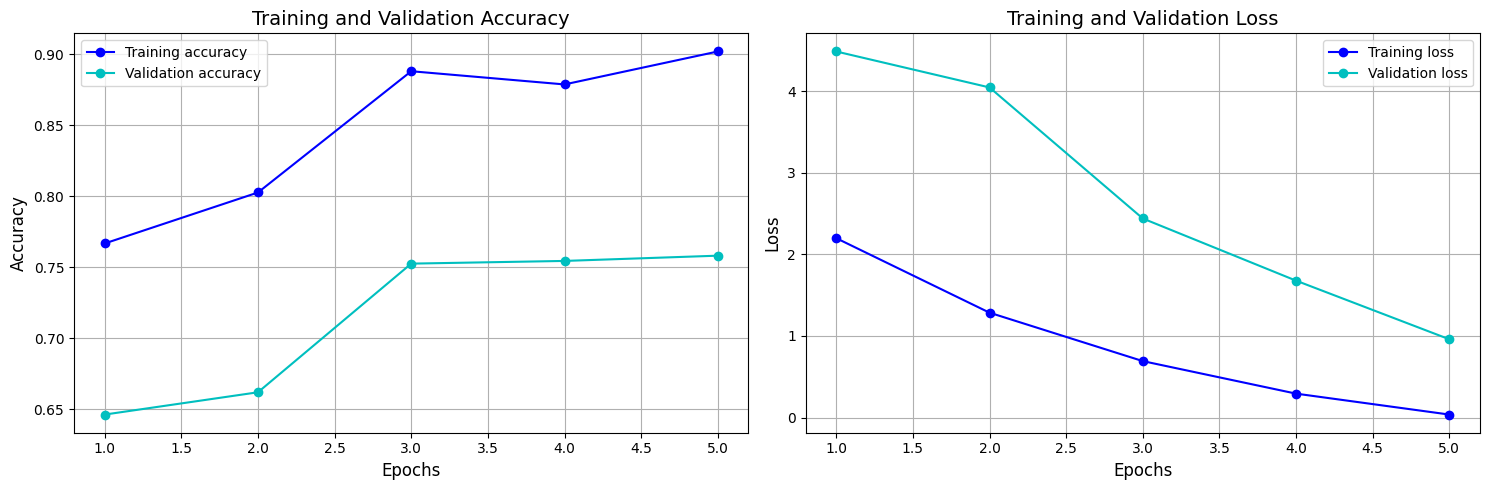

In [ ]:
show_history_plot(history_AlexNet.history)

In [ ]:
evaluation_matrix(AlexNet_model)

             Loss       Accuracy 
----------------------------------
Train        0.22023    0.90926   
Validation   0.41579    0.79356   
Test         0.33952    0.88975   


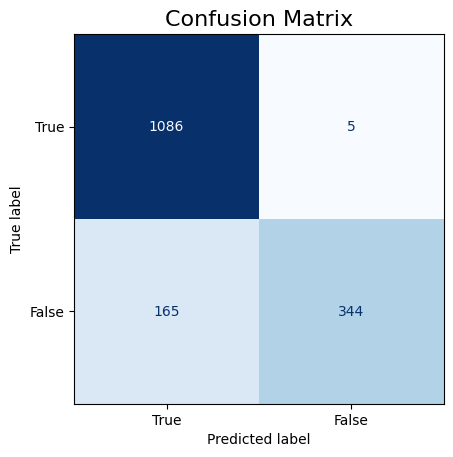

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(AlexNet_model)

## CNN

In [ ]:
CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Dense(2, activation='softmax'))

CNN_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

#### Train the Model

In [ ]:
history_CNN = CNN_model.fit(train_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5
187/187 [==============================] - 2231s 12s/step - loss: 4.5747 - accuracy: 0.7824 - val_loss: 0.4386 - val_accuracy: 0.8105
Epoch 2/5
187/187 [==============================] - 87s 467ms/step - loss: 0.4323 - accuracy: 0.8159 - val_loss: 0.4367 - val_accuracy: 0.8274
Epoch 3/5
187/187 [==============================] - 84s 450ms/step - loss: 0.3844 - accuracy: 0.8332 - val_loss: 0.4043 - val_accuracy: 0.8399
Epoch 4/5
187/187 [==============================] - 91s 487ms/step - loss: 0.3439 - accuracy: 0.8562 - val_loss: 0.4068 - val_accuracy: 0.8368
Epoch 5/5
187/187 [==============================] - 83s 443ms/step - loss: 0.2986 - accuracy: 0.8747 - val_loss: 0.4340 - val_accuracy: 0.8293


#### Evaluate the Model

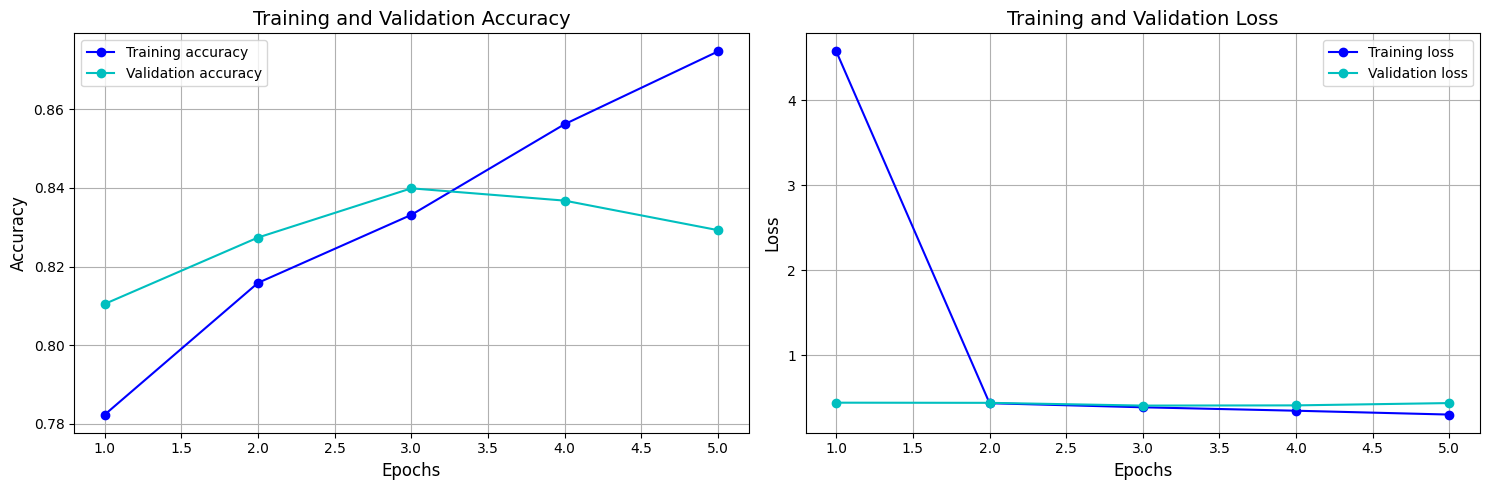

In [ ]:
show_history_plot(history_CNN.history)

In [ ]:
evaluation_matrix(CNN_model)

             Loss       Accuracy  
----------------------------------
Train        0.23578    0.90625   
Validation   0.43400    0.82927   
Test         0.48847    0.81375   


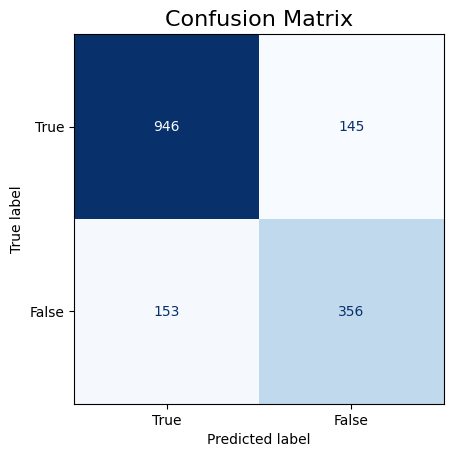

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(CNN_model)

In [ ]:
final_validation_accuracy = history_CNN.history['val_accuracy'][-1]

def index(final_validation_accuracy ):
    # Calculate accuracy


    # Render HTML template with accuracy
    return render_template('1.html', accuracy=final_validation_accuracy)

if __name__ == '__main__':
    app.run(debug=True)

## ResNet

In [ ]:
# Import the ResNet152 model
from keras.applications import ResNet152
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.optimizers import Adam

# Load pre-trained ResNet152 model without the top layer (include_top=False)
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: 'all' and 'hem'

# Create the final model
ResNet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
ResNet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
ResNet_model.summary()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Blood cancer work/dataset/train'

#### Train the Model

In [ ]:
# Train the model
history_ResNet = ResNet_model.fit(train_gen,
                                  steps_per_epoch=train_steps,
                                  validation_data=valid_gen,
                                  validation_steps=validation_steps,
                                  epochs=1)


NameError: name 'train_steps' is not defined

#### Evaluate the Model

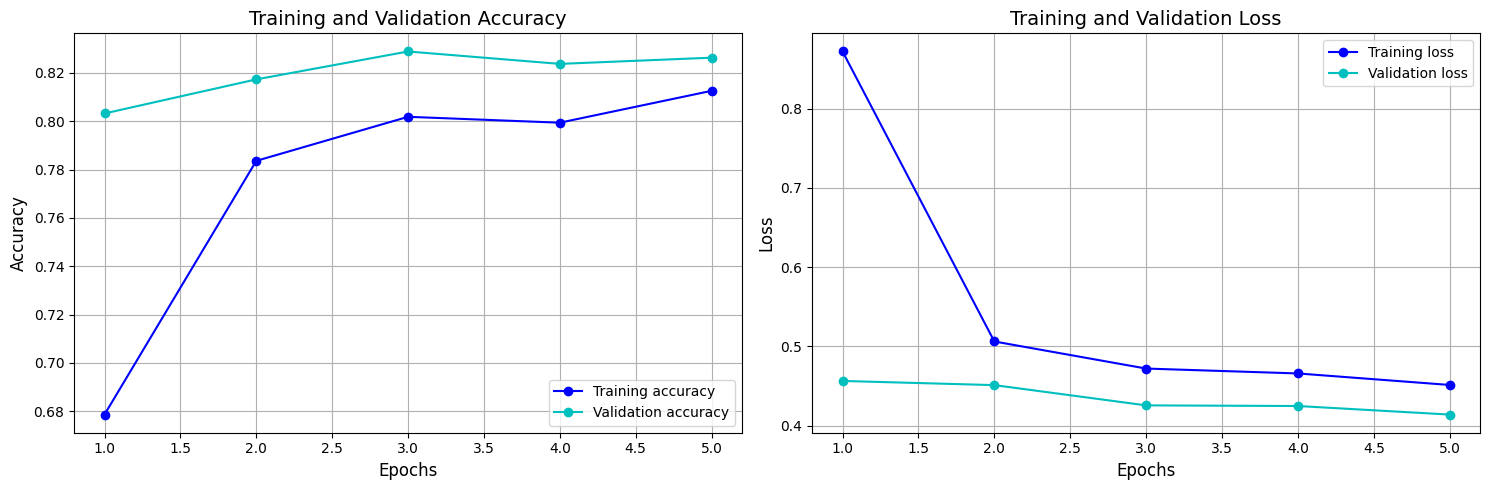

In [ ]:
show_history_plot(history_ResNet.history)

In [ ]:
evaluation_matrix(ResNet_model)

             Loss       Accuracy  
----------------------------------
Train        0.40963    0.83250   
Validation   0.41025    0.82864   
Test         0.42747    0.82625   


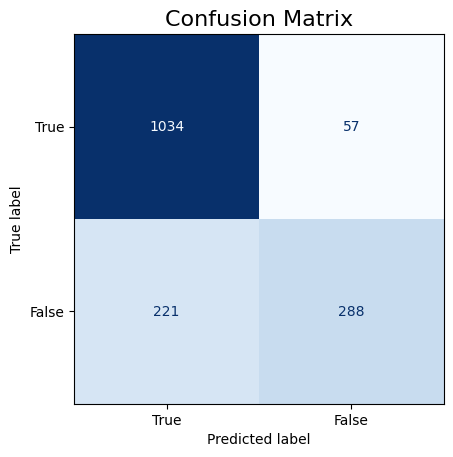

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(ResNet_model)